## Autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## Libraries

In [2]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pywt
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import detrend, butter, filtfilt
from scipy.linalg import hankel, svd, eig
import ipywidgets as widgets
from IPython.display import display
from signalepy import plot, settings, utils, analysis
import numpy as np
from collections import OrderedDict
from typing import Tuple,Dict
from numpy.typing import NDArray
from numba import jit, prange
import numpy as np
from numpy.typing import NDArray
from typing import Tuple
from dataclasses import dataclass, field

## Parameters

### Accceleration data

**File name and location**

In [3]:
file_name = 'cable_acceleration.txt'
file_location = utils.get_tests_files_location(file_name)


**Import acceleration data**

In [4]:
label ='Z'

In [5]:
df = utils.import_sts_acceleration_txt(file_location, label)

Skipping line due to invalid data: POSITION       Time             X1         Y1         Z1         IW1         X2         Y2         Z2         IW2. Error: could not convert string to float: 'Time'


In [6]:
def filter_time_window(
    df: pd.DataFrame, label: str = None, start_time: float = None, window_size: float = None
) -> pd.DataFrame:
    """
    Filters a DataFrame to include only data within a specified time window.

    Args:
        df: DataFrame containing time-series data with a 'Time' column.
        label: Label or identifier (Unused in the current implementation).
        start_time: Start time of the window.
        window_size: Size of the time window.

    Returns:
        A new DataFrame containing only the data within the specified time window,
        or the original DataFrame if start_time or window_size is None.

    Assumptions:
        - The DataFrame has a column named 'Time' with numerical time values.
        - start_time and window_size are numerical values.
    """
    if start_time is None or window_size is None:
        return df

    end_time = start_time + window_size

    # Filter the DataFrame
    filtered_df = df[(df["Time"] >= start_time) & (df["Time"] <= end_time)]

    return filtered_df


In [7]:
def estimate_n(df):

    delta_t = df['Time'][1] - df['Time'][0]

    time_n = df['Time'].iloc[-1]
    
    n = 0

    while delta_t * 2**n < time_n:
        n += 1
    
    return n - 1

In [8]:
n = estimate_n(df)

In [9]:
print(n)

16


In [10]:
total_time = df['Time'].iloc[-1]
print(f'esperado n**2 = {len(df['Time'])}')

esperado n**2 = 67108


n 1024
window size 10.24


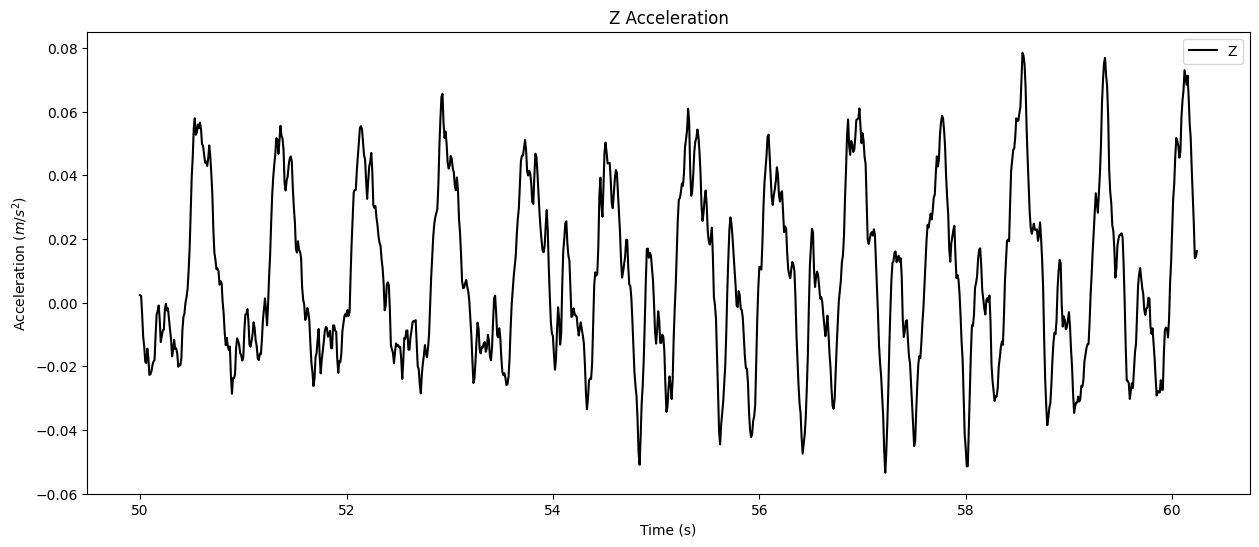

In [11]:
start_time = 50
n = 10
window_size = 0.01 * 2**n
print(f'n {2**n}')
print(f'window size {window_size}')
df = filter_time_window(df, label, start_time, window_size)
plot.acceleration(df, label, color='k')

## FFT analysis

In [12]:
label_corrected = f'{label} corrected'
df = analysis.baseline_correction(df, label, label_corrected)

In [13]:
df_fft = analysis.calculate_fft(df, label_corrected)

In [14]:
df_fft

,Frequency,Z corrected Magnitude
0,0.000000,1.110223e-15
1,0.097561,8.650753e-01
2,0.195122,4.010919e-01
3,0.292683,4.549077e-01
4,0.390244,3.737311e-01
...,...,...
507,49.463415,3.754495e-03
508,49.560976,3.605866e-03
509,49.658537,3.662488e-03
510,49.756098,3.577893e-03


## Denoising

In [15]:
label_filtered= f'{label} filtered'
threshold_percentage = 20
analysis.fft_filter(df=df, threshold_percentage=threshold_percentage, label=label_corrected, label_filtered=label_filtered)

,Time,Z Acceleration,Z corrected Acceleration,Z filtered Acceleration
4999,50.00,0.002324,-0.003319,0.010701
5000,50.01,0.002158,-0.003489,0.006311
5001,50.02,-0.003840,-0.009492,0.001701
5002,50.03,-0.010726,-0.016382,-0.003032
5003,50.04,-0.013874,-0.019535,-0.007774
...,...,...,...,...
6019,60.20,0.033612,0.023441,0.027231
6020,60.21,0.024874,0.014699,0.024747
6021,60.22,0.013988,0.003809,0.021843
6022,60.23,0.014414,0.004230,0.018517


In [16]:
magnitude_type = 'calculated'
magnitude_factor = 1000
df_fft = analysis.calculate_fft(df, label_filtered, magnitude_type, magnitude_factor)

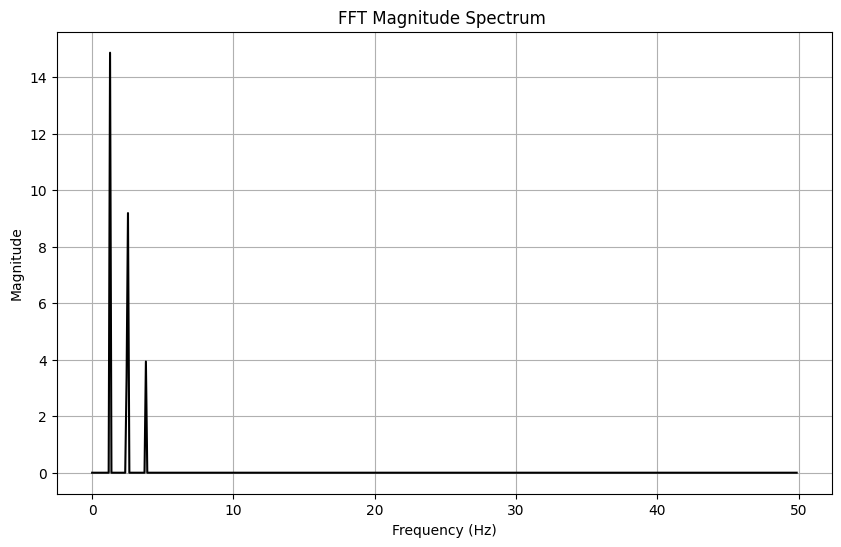

In [17]:
plot.fft_results(df_fft, label_filtered, 'k')

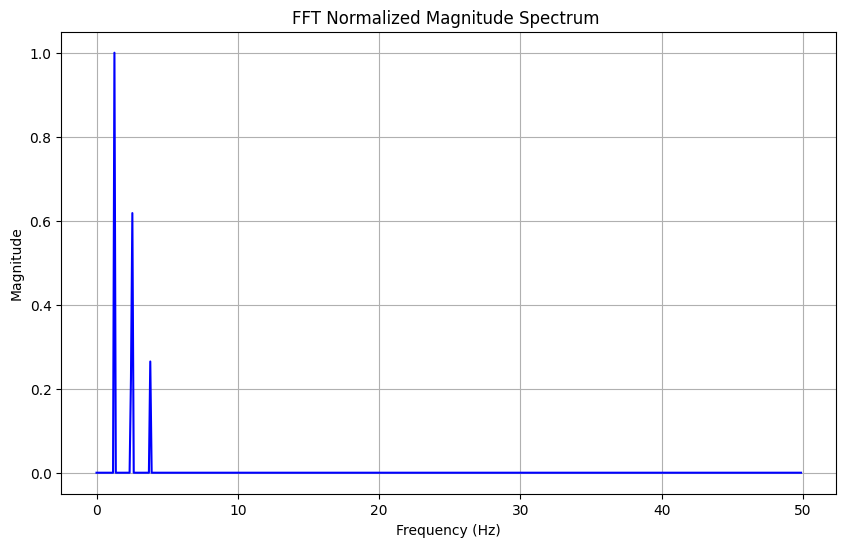

In [18]:
plot.normalized_fft_results(df_fft, label_filtered,'b')

In [19]:
wavelet ='morl'
min_scale = 1
max_scale = 32

In [20]:
spectrum, frequencies = analysis.cwt(df, label, wavelet, min_scale, max_scale)

In [21]:
gif_name = "wavelet_spectrum.gif"
file_location_gif = utils.get_results_files_location(gif_name)

In [22]:
analysis.wavelet_spectrum(df, label, wavelet, min_scale, max_scale, save_gif=True, file_location=file_location_gif, magnitude_type=magnitude_type, magnitude_factor=magnitude_factor)

interactive(children=(IntSlider(value=30, description='Elevation', max=90, step=5), IntSlider(value=0, descrip…

GIF saved as 'wavelet_spectrum.gif'


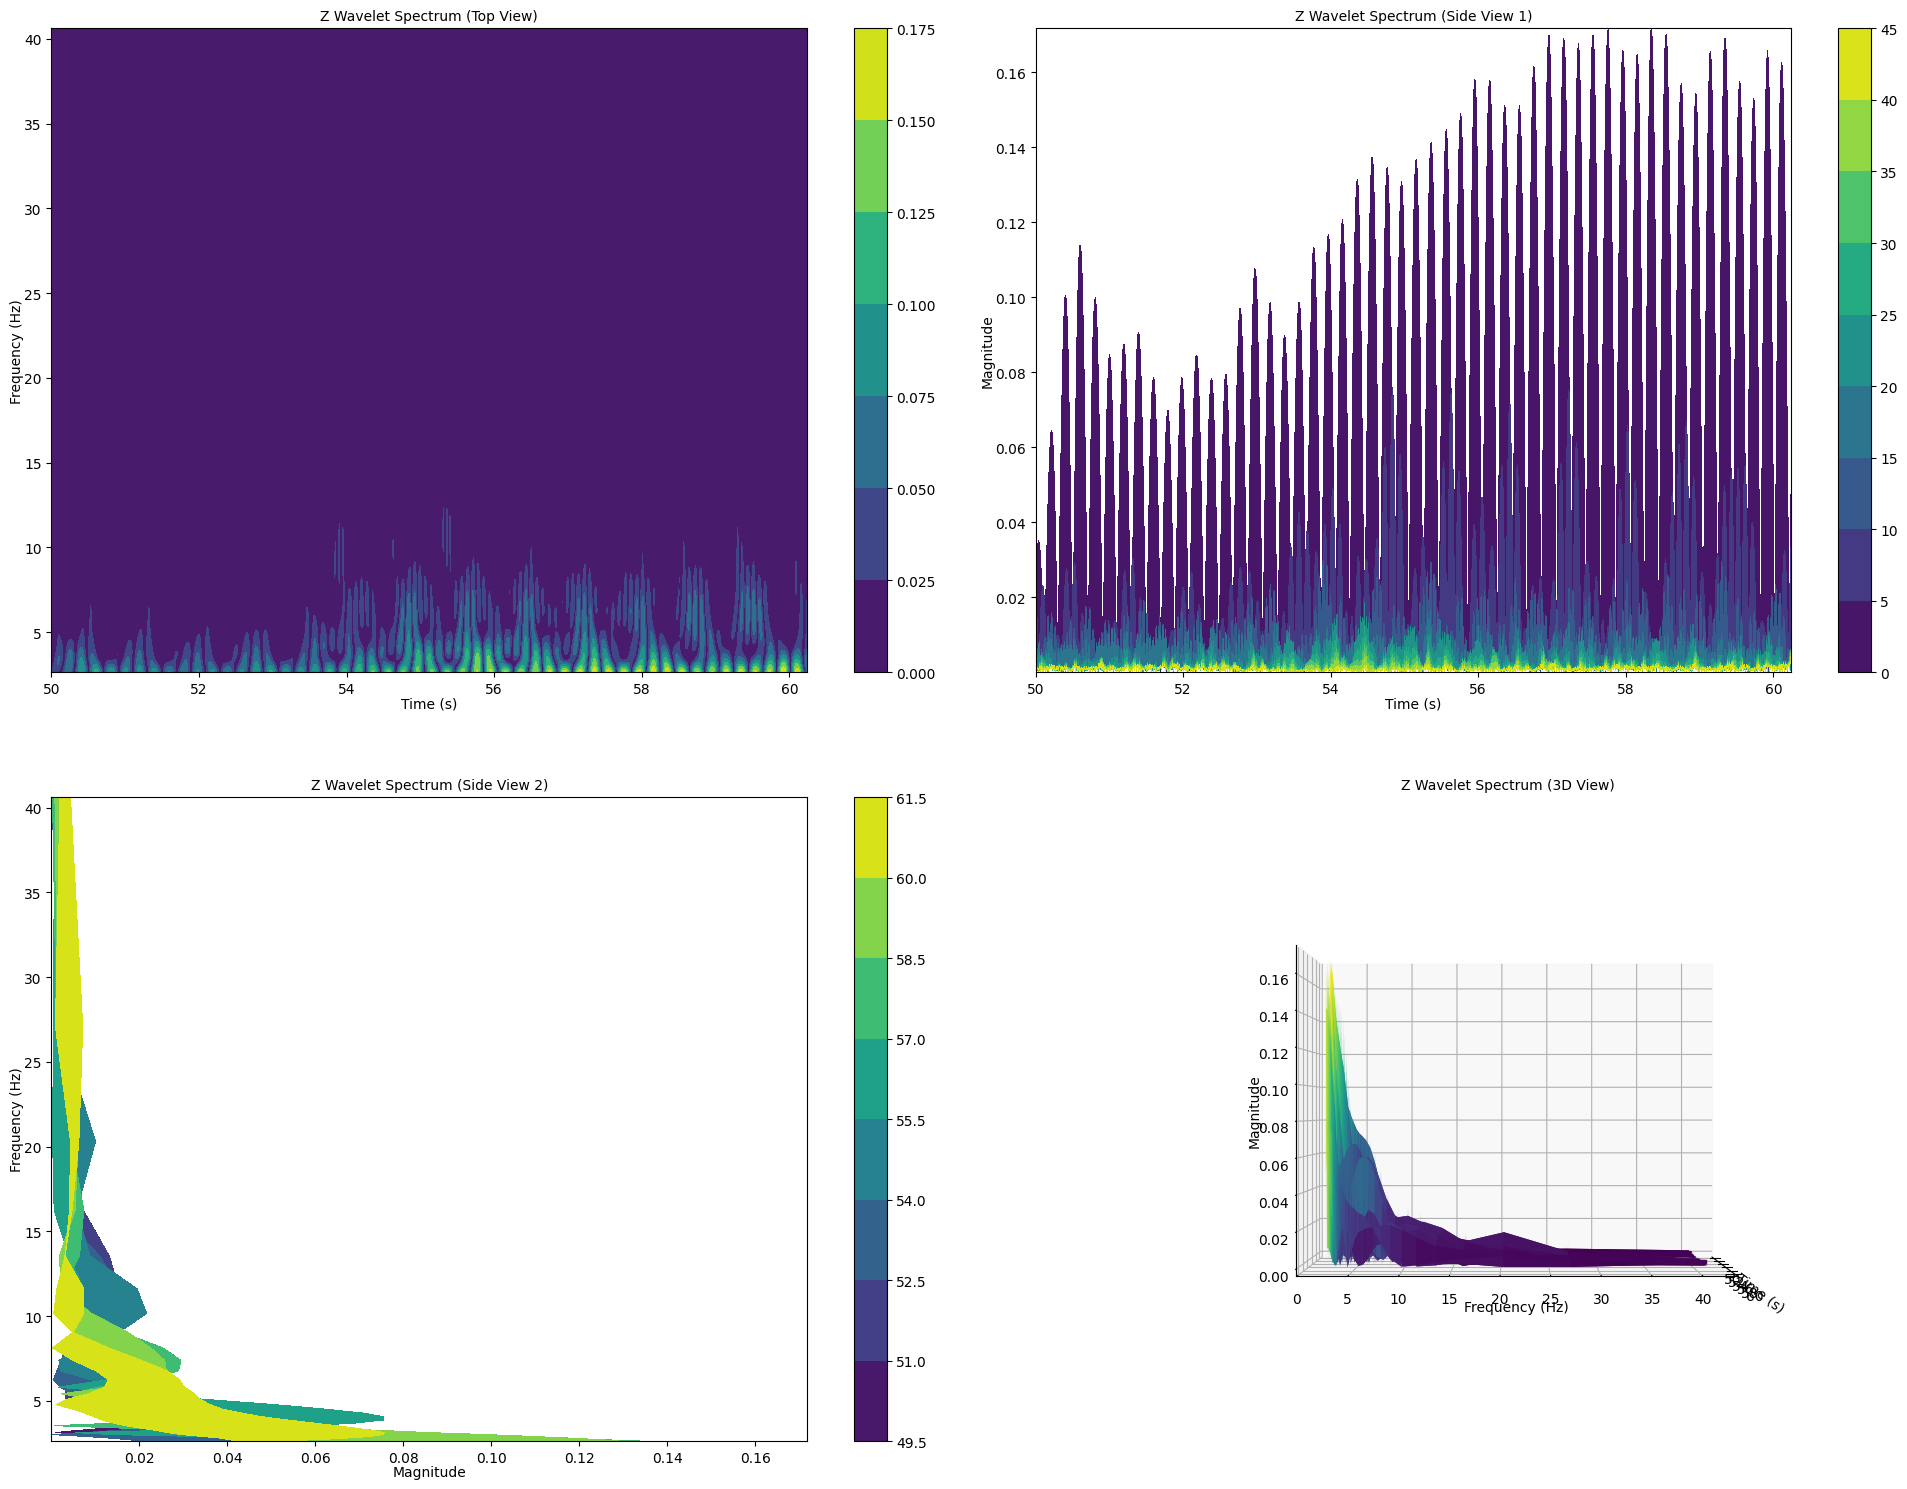

In [23]:
plot.wavelet_spectrum_views(df, spectrum, frequencies, label)

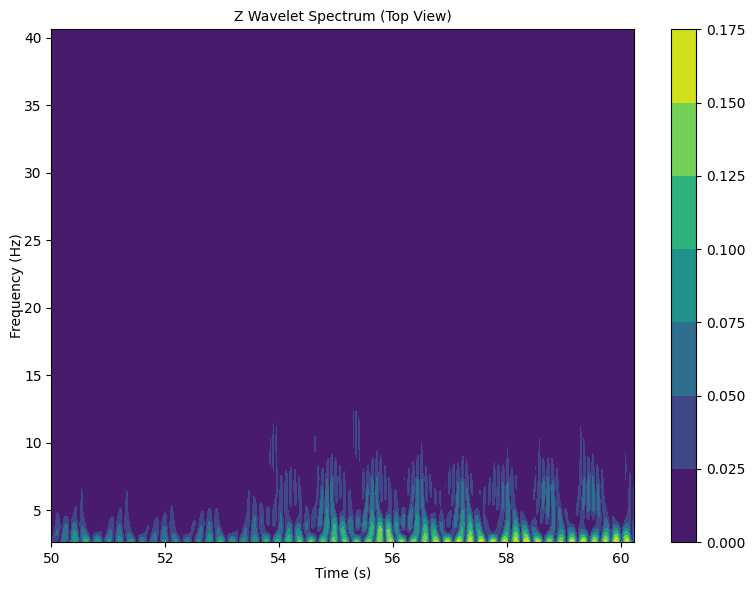

In [24]:
plot.wavelet_spectrum_time_frequency(df, spectrum, frequencies, label)

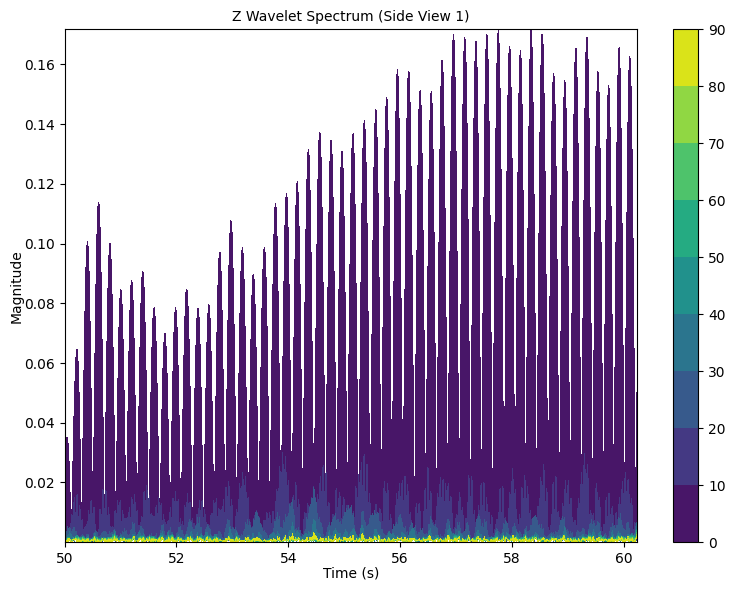

In [25]:
plot.wavelet_spectrum_time_magnitude(df, spectrum, frequencies, label)

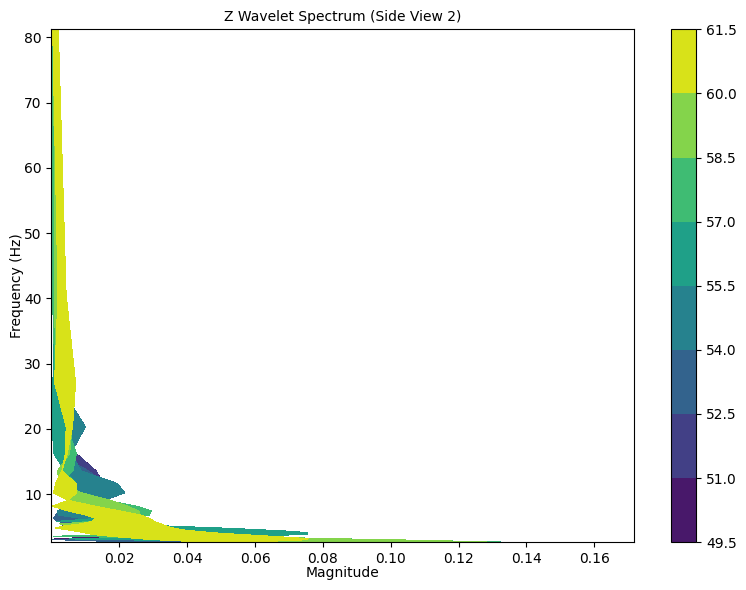

In [26]:
plot.wavelet_spectrum_frequency_magnitude(
    df,
    spectrum,
    frequencies,
    label
)

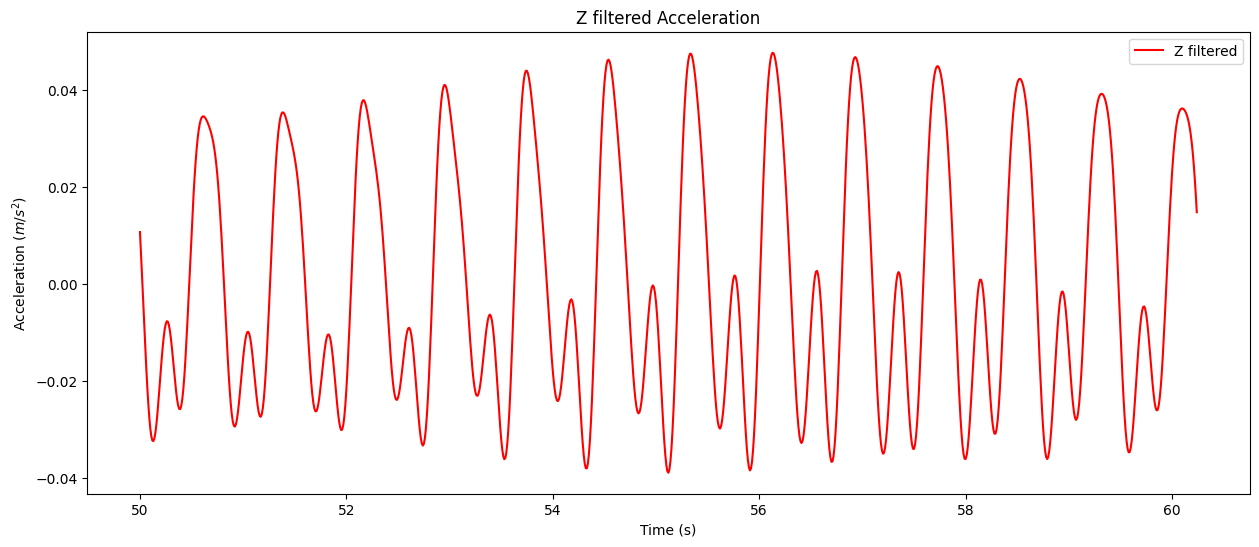

In [27]:
plot.acceleration(df, label_filtered)

In [28]:
df_fft_filtered = analysis.calculate_fft(df, label_filtered)

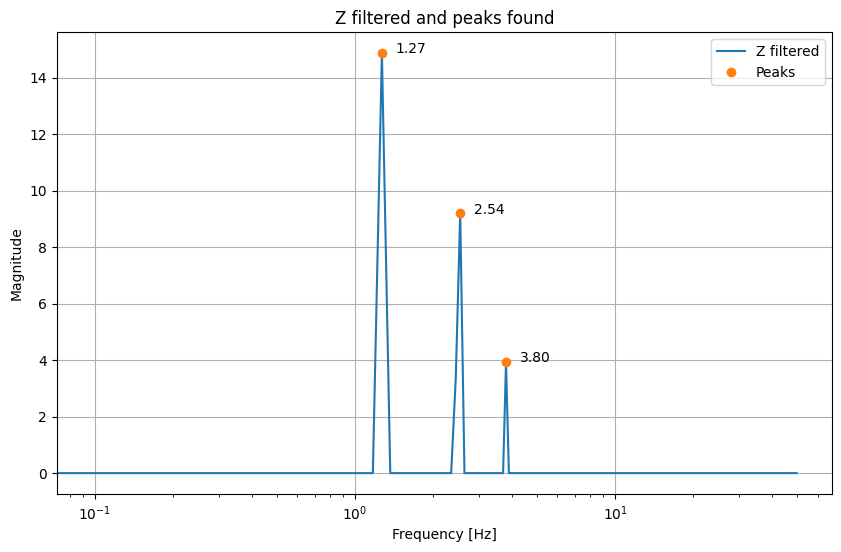

In [29]:
#plot.peaks(df_fft, label_filtered, log_scale=True)
plot.peaks(df_fft, label_filtered, log_scale=True)

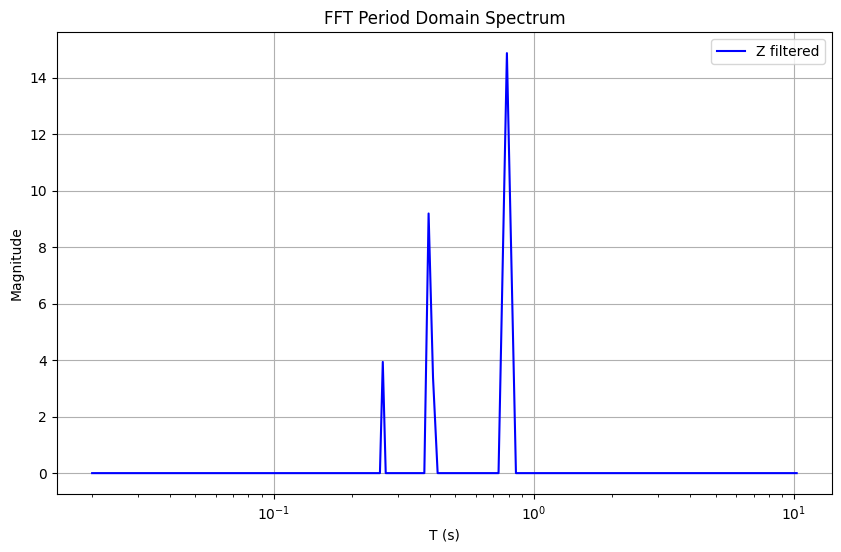

In [30]:
plot.fft_results_period_domain(df_fft, label_filtered, color='blue', log_scale=True)

In [31]:
frequencies, power_spectrum, fn0, zeta0, number_poles = analysis.ssi_cov(df, label_filtered, Ts=20, Nmin=2, Nmax=32, threshold=1000)

In [32]:
frequencies

array([0.00097561, 0.00195122, 0.00292683, 0.00390244, 0.00487805,
       0.00585366, 0.00682927, 0.00780488, 0.00878049, 0.0097561 ,
       0.01073171, 0.01170732, 0.01268293, 0.01365854, 0.01463415,
       0.01560976, 0.01658537, 0.01756098, 0.01853659, 0.0195122 ,
       0.0204878 , 0.02146341, 0.02243902, 0.02341463, 0.02439024,
       0.02536585, 0.02634146, 0.02731707, 0.02829268, 0.02926829,
       0.0302439 , 0.03121951, 0.03219512, 0.03317073, 0.03414634,
       0.03512195, 0.03609756, 0.03707317, 0.03804878, 0.03902439,
       0.04      , 0.04097561, 0.04195122, 0.04292683, 0.04390244,
       0.04487805, 0.04585366, 0.04682927, 0.04780488, 0.04878049,
       0.0497561 , 0.05073171, 0.05170732, 0.05268293, 0.05365854,
       0.05463415, 0.05560976, 0.05658537, 0.05756098, 0.05853659,
       0.0595122 , 0.0604878 , 0.06146341, 0.06243902, 0.06341463,
       0.06439024, 0.06536585, 0.06634146, 0.06731707, 0.06829268,
       0.06926829, 0.0702439 , 0.07121951, 0.07219512, 0.07317

In [33]:
def plot_ssi_cov(
    frequencies: np.ndarray,
    power_spectrum: np.ndarray,
    label: str,
    fn0: np.ndarray = None,
    zeta0: np.ndarray = None,
    threshold: float = 0.01,
    color: str = "k",
):
    """
    Plots the SSCOV results and optionally the stability diagram.

    Args:
        frequencies: Frequencies corresponding to the power spectrum.
        power_spectrum: Power spectrum values.
        label: Data label (e.g., 'X').
        fn0: Natural Frequencies
        zeta0: Damping Ratio
        threshold: Threshold

    Returns:
        None (displays the plot).
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(frequencies, power_spectrum, color=color)
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_ylabel("Power")
    ax1.tick_params("y")
    ax1.grid(True)
    ax1.legend(loc="upper left", title=str(label))

    # Plot stability diagram on a second y-axis
    if fn0 is not None and zeta0 is not None:
        try:
            # Create the stability diagram based on threshold
            number_of_poles = np.zeros_like(frequencies)
            for i, freq in enumerate(frequencies):
                if freq > 0:
                    number_of_poles[i] = np.sum((fn0 >= freq - threshold) & (fn0 <= freq + threshold))

            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.plot(
                frequencies,
                number_of_poles,
                marker="o",
                linestyle="",
                color="tab:orange",
                label="Number of Poles",
            )
            ax2.set_ylabel(
                "Number of Poles", color="tab:orange"
            )  # we already handled the x-label with ax1
            ax2.tick_params(axis="y", labelcolor="tab:orange")
            #combine legends from both axes
            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines + lines2, labels + labels2, loc='upper left')

            # Check that both axes are covered
            fig.tight_layout()
            plt.title(f"Power Spectrum and Stability Diagram ({label})")
        except ValueError as ve:
            print(f"ValueError plotting stability data: {ve}. Skipping stability plot.")
        except Exception as e:
            print(f"Error plotting stability data: {e}. Skipping stability plot.")
    else:
        plt.title(f"Power Spectrum ({label})")

    plt.show()

In [34]:
len(frequencies)

512

In [35]:
len(power_spectrum)

512

In [36]:
len(fn0)

20

In [37]:
len(zeta0)

20

In [38]:
len(number_poles)

512

C:\Users\ingah\AppData\Local\Temp\ipykernel_23908\1310405658.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc="upper left", title=str(label))


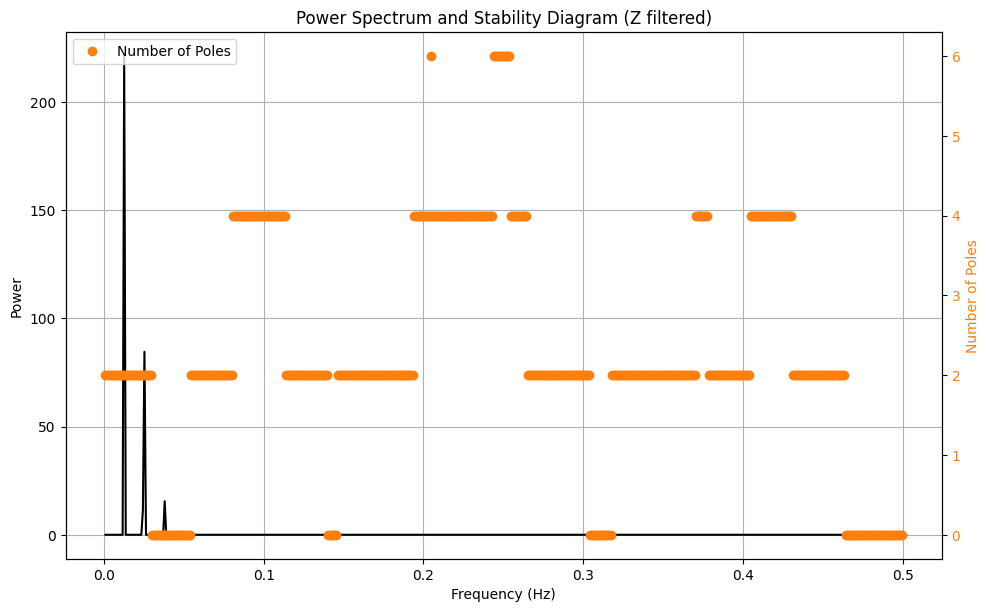

In [39]:
plot_ssi_cov(frequencies, power_spectrum, label_filtered, fn0, zeta0, threshold=0.03)

In [40]:
@jit(nopython=True, parallel=True)
def blockToeplitz_jit(IRF: NDArray) -> Tuple[NDArray, NDArray, NDArray, NDArray]:
    """
    Constructs a block Toeplitz matrix from the given IRF and performs SVD.

    Args:
        IRF: Impulse Response Function (IRF) as a NumPy array.

    Returns:
        A tuple containing:
            U: Left singular vectors from SVD.
            S: Singular values from SVD.
            V: Right singular vectors from SVD.
            T1: The constructed block Toeplitz matrix.

    Assumptions:
        - IRF has shape (:, :, n) where n is odd.
        - IRF is appropriately sized for the round() operation to be meaningful.
    """
    N1 = int(round(IRF.shape[2] / 2) - 1)
    M = IRF.shape[1]
    T1 = np.zeros(((N1) * M, (N1) * M), dtype=np.complex128)

    for oo in prange(N1):
        for ll in prange(N1):
            T1[(oo) * M : (oo + 1) * M, (ll) * M : (ll + 1) * M] = IRF[:, :, N1 - 1 + oo - ll + 1]

    U, S, Vt = np.linalg.svd(T1)
    V = Vt.T

    return U, S, V, T1

In [41]:
@dataclass
class SSICOV:
    """
    Implements the Stochastic Subspace Identification with Covariance (SSICOV) method for modal identification.

    Args:
        df: DataFrame containing time and acceleration data.
        labels: List of labels for the acceleration columns in the DataFrame (e.g., ["X", "Y", "Z"]).
        Nmin: Minimum model order to consider. Defaults to 2.
        Nmax: Maximum model order to consider. Defaults to 32.

    Returns:
        None

    Assumptions:
        - The DataFrame contains columns named "{label} Acceleration" for each label in the 'labels' list.
        - Nmax is greater than Nmin.
        - A module called 'analysis' is available and returns a dataframe containing "Frequency" and "{label} Magnitude".
    """

    df: pd.DataFrame  # DataFrame containing time and acceleration data
    labels: list[str]  # List of labels for the acceleration columns in the DataFrame
    Nmin: int = 2
    Nmax: int = 32
    Nc: int = field(init=False, repr=False)  # Number of channels, determined by the length of labels
    fs: float = field(init=False, repr=False)  # Sampling frequency
    Ts: float = field(init=False, repr=False)  # Total time
    M: int = field(init=False, repr=False) #Number of points of the FFT

    def __post_init__(self):
        """
        Post initialization to validate input parameters and calculate sampling rate if necessary.

        Raises:
            ValueError: If Nmax is not greater than Nmin, or if the required columns are missing.
        """
        if self.Nmax <= self.Nmin:
            raise ValueError("Nmax must be greater than Nmin")

        self.Nc = len(self.labels)  # Determine Nc from the length of labels

        # Verify that necessary columns exist
        for label in self.labels:
            acc_column = f'{label} Acceleration'
            if acc_column not in self.df.columns:
                raise ValueError(f"Column '{acc_column}' not found in DataFrame")

        self.delta_t = self.df['Time'].iloc[1] - self.df['Time'].iloc[0]
        self.fs = 1 / self.delta_t
        self.Ts = self.df['Time'].iloc[-1] - self.df['Time'].iloc[0] # subtract initial time
        # Ensure M is calculated after fs and Ts are known:
        self.M = int(round(self.Ts * self.fs))

    def NexT(self) -> NDArray:
        """
        Computes the Impulse Response Function (IRF) using FFT from the analysis module and the Next method.

        Args:
            None

        Returns:
            IRF: Impulse Response Function as a NumPy array.

        Assumptions:
            - The sampling frequency 'fs' and time segment length 'Ts' are properly defined.
            - The 'analysis' module and its 'calculate_fft' function are accessible.
        """
        IRF = np.zeros((self.Nc, self.Nc, self.M - 1), dtype=complex)

        # Now read acceleration data for all channels:
        accelerations = []
        for label in self.labels:
            fft_df = analysis.calculate_fft(  # Get the frequency and magnitude as a DataFrame
                self.df,
                label,  # Pass the channel's label to calculate_fft
            )
            magnitude_column = f'{label} Magnitude'
            if magnitude_column not in fft_df.columns:
                raise ValueError(f"Column '{magnitude_column}' not found in fft_df")
            y = fft_df[magnitude_column].to_numpy() #access just magnitude
            accelerations.append(y)

        for oo in range(self.Nc):
            for jj in range(self.Nc):
                # cross-correlation: ifft[cross-power spectrum]
                h0 = np.fft.ifft(accelerations[oo] * np.conjugate(accelerations[jj])) # Ensure numpy.conjugate

                # impulse response function
                IRF[oo, jj, :] = np.real(h0[0 : self.M - 1]) #Use self.M

        return IRF

    def blockToeplitz(self, IRF: NDArray) -> Tuple[NDArray, NDArray, NDArray, NDArray]:
        """
        Constructs a block Toeplitz matrix from the given IRF and performs SVD.

        Args:
            IRF: Impulse Response Function (IRF) as a NumPy array.

        Returns:
            A tuple containing:
                U: Left singular vectors from SVD.
                S: Singular values from SVD.
                V: Right singular vectors from SVD.
                T1: The constructed block Toeplitz matrix.

        Assumptions:
            - IRF has shape (:, :, n) where n is odd.
        """
        return blockToeplitz_jit(IRF)

    def modalID(self, U, S, Nmodes, Nyy, fs):
        """
        Identifies modal parameters (frequency, damping, mode shape) from SVD results.

        Args:
            U: Left singular vectors from SVD.
            S: Singular values from SVD.
            Nmodes: Number of modes to identify.
            Nyy: Number of output channels.
            fs: Sampling frequency (Hz).

        Returns:
            A tuple containing:
                fn: Natural frequencies (Hz).
                zeta: Damping ratios.
                phi: Mode shapes.

        Assumptions:
            - U and S are the outputs of a Singular Value Decomposition (SVD).
        """
        S = np.diag(S)
        if Nmodes >= S.shape[0]:
            print("changing the number of modes to the maximum possible")
            Nmodes = S.shape[0]
        dt = 1 / self.fs
        O = np.matmul(U[:, 0:Nmodes], np.sqrt(S[0:Nmodes, 0:Nmodes]))
        IndO = min(Nyy, len(O[:, 0]))
        C = O[0:IndO, :]
        jb = O.shape[0] / IndO
        ao = int((IndO) * (jb - 1))
        bo = int(len(O[:, 0]) - (IndO) * (jb - 1))
        co = len(O[:, 0])
        A = np.matmul(np.linalg.pinv(O[0:ao, :]), O[bo:co, :])
        [Vi, Di] = np.linalg.eig(A)
        mu = np.log(np.diag(np.diag(Vi))) / dt
        fno = np.abs(mu) / (2 * np.pi)
        fn = fno[np.ix_(*[range(0, i, 2) for i in fno.shape])]
        zetaoo = -np.real(mu) / np.abs(mu)
        zeta = zetaoo[np.ix_(*[range(0, i, 2) for i in zetaoo.shape])]
        phi0 = np.real(np.matmul(C[0:IndO, :], Di))
        phi = phi0[:, 1::2]
        return fn, zeta, phi

    def stabilityCheck(self, fn0, zeta0, phi0, fn1, zeta1, phi1):
        """
        Performs stability checks based on frequency, damping, and mode shape.

        Args:
            fn0: Natural frequencies from the previous model order.
            zeta0: Damping ratios from the previous model order.
            phi0: Mode shapes from the previous model order.
            fn1: Natural frequencies from the current model order.
            zeta1: Damping ratios from the current model order.
            phi1: Mode shapes from the current model order.

        Returns:
            A tuple containing:
                fn: Stable natural frequencies.
                zeta: Stable damping ratios.
                phi: Stable mode shapes.
                MAC: Mode shape correlation values.
                stability_status: Stability status flags.

        Assumptions:
            - Input modal parameters are from models of adjacent orders.
        """
        eps_freq = 2e-2
        eps_zeta = 4e-2
        eps_MAC = 5e-2
        stability_status = []
        fn = []
        zeta = []
        phi_list = []
        MAC = []

        # frequency stability
        N0 = len(fn0)
        N1 = len(fn1)

        for rr in range(N0 - 1):
            for jj in range(N1 - 1):
                stab_fn = self.errorcheck(fn0[rr], fn1[jj], eps_freq)
                stab_zeta = self.errorcheck(zeta0[rr], zeta1[jj], eps_zeta)
                stab_phi, dummyMAC = self.getMAC(phi0[:, rr], phi1[:, jj], eps_MAC)

                # get stability status
                if stab_fn == 0:
                    stabStatus = 0  # new pole
                elif stab_fn == 1 and stab_phi == 1 and stab_zeta == 1:
                    stabStatus = 1  # stable pole
                elif stab_fn == 1 and stab_zeta == 0 and stab_phi == 1:
                    stabStatus = 2  # pole with stable frequency and vector
                elif stab_fn == 1 and stab_zeta == 1 and stab_phi == 0:
                    stabStatus = 3  # pole with stable frequency and damping
                elif stab_fn == 1 and stab_zeta == 0 and stab_phi == 0:
                    stabStatus = 4  # pole with stable frequency
                else:
                    raise ValueError("Error: stability_status is undefined")

                fn.append(fn1[jj])
                zeta.append(zeta1[jj])
                phi_list.append(phi1[:, jj])
                MAC.append(dummyMAC)
                stability_status.append(stabStatus)

        ind = np.argsort(fn)
        fn = np.sort(fn)
        zeta = np.array(zeta)[ind]
        phi = np.column_stack(phi_list)[:, ind]
        MAC = np.array(MAC)[ind]
        stability_status = np.array(stability_status)[ind]

        return fn, zeta, phi, MAC, stability_status

    def errorcheck(self, xo, x1, eps):
        """
        Checks if the relative difference between two values is within a tolerance.

        Args:
            xo: First value.
            x1: Second value.
            eps: Tolerance.

        Returns:
            1 if the relative difference is within the tolerance, 0 otherwise.

        Assumptions:
            - Inputs are scalar values.
        """
        return 1 if abs(1 - xo / x1) < eps else 0

    def getMAC(self, x0, x1, eps):
        """
        Computes the Mode Assurance Criterion (MAC) between two mode shapes.

        Args:
            x0: First mode shape.
            x1: Second mode shape.
            eps: Tolerance for MAC value.

        Returns:
            A tuple containing:
                y: 1 if MAC is above the threshold, 0 otherwise.
                dummyMAC: MAC value.

        Assumptions:
            - Input mode shapes are vectors.
        """
        Num = np.abs(np.dot(x0.flatten(), x1.flatten())) ** 2
        D1 = np.dot(x0.flatten(), x0.flatten())
        D2 = np.dot(x1.flatten(), x1.flatten())
        dummyMAC = Num / (D1 * D2)
        return (1 if dummyMAC > (1 - eps) else 0), dummyMAC

    def flip_dic(self, a) -> OrderedDict:
        """
        Reverses the order of elements in a dictionary.

        Args:
            a: Input dictionary.

        Returns:
            dreversed: Reversed dictionary.

        Assumptions:
            - Input is a dictionary.
        """
        d = OrderedDict(a)
        dreversed = OrderedDict()
        for k in reversed(d):
            dreversed[k] = d[k]
        return dreversed

    def getStablePoles(self, fn, zeta, phi, MAC, stablity_status):
        """
        Extracts stable poles based on the stability status.

        Args:
            fn: Natural frequencies.
            zeta: Damping ratios.
            phi: Mode shapes.
            MAC: Mode shape correlation values.
            stablity_status: Stability status flags.

        Returns:
            A tuple containing:
                fnS: Stable natural frequencies.
                zetaS: Stable damping ratios.
                phiS: Stable mode shapes.
                MACS: MAC values for stable poles.

        Assumptions:
            - Input modal parameters and stability statuses are properly aligned.
        """
        fnS = []
        zetaS = []
        phiS = []
        MACS = []

        for i in range(len(fn)):
            for j in range(len(stablity_status[i])):
                if stablity_status[i][j] == 1:
                    fnS.append(fn[i][j])
                    zetaS.append(zeta[i][j])
                    phiS.append(phi[i][:, j])
                    MACS.append(MAC[i][j])

        fnS = np.array(fnS)
        zetaS = np.array(zetaS)
        phiS = np.array(phiS).T
        MACS = np.array(MACS)

        # Remove negative damping
        valid_indices = zetaS > 0
        fnS = fnS[valid_indices]
        phiS = phiS[:, valid_indices]
        MACS = MACS[valid_indices]
        zetaS = zetaS[valid_indices]

        # Normalize mode shape
        for oo in range(phiS.shape[1]):
            phiS[:, oo] = phiS[:, oo] / np.max(np.abs(phiS[:, oo]))
            if np.diff(phiS[0:2, oo]) < 0:
                phiS[:, oo] = -phiS[:, oo]

        return fnS, zetaS, phiS, MACS

    def run_stability(self, U, S):
        """
        Performs the stability analysis over a range of model orders.

        Args:
            U: Left singular vectors from SVD.
            S: Singular values from SVD.

        Returns:
            A tuple containing:
                fn2: Natural frequencies for each model order.
                zeta2: Damping ratios for each model order.
                phi2: Mode shapes for each model order.
                MAC: MAC values for each model order.
                stability_status: Stability status for each model order.

        Assumptions:
            - U and S are the outputs of a Singular Value Decomposition (SVD).
        """
        fn1_list = []
        i_list = []
        kk = 0
        fn2, zeta2, phi2, MAC, stability_status = {}, {}, {}, {}, {}

        for i in range(self.Nmax, self.Nmin - 1, -1):
            if kk == 0:
                fn0, zeta0, phi0 = self.modalID(U, S, i, self.Nc, self.fs)
            else:
                fn1, zeta1, phi1 = self.modalID(U, S, i, self.Nc, self.fs)
                fn1_list.append(fn1)
                i_list.append(i)

                [a, b, c, d, e] = self.stabilityCheck(fn0, zeta0, phi0, fn1, zeta1, phi1)

                fn2[kk - 1] = a
                zeta2[kk - 1] = b
                phi2[kk - 1] = c
                MAC[kk - 1] = d
                stability_status[kk - 1] = e

                fn0 = fn1
                zeta0 = zeta1
                phi0 = phi1
            kk = kk + 1

        return fn2, zeta2, phi2, MAC, stability_status

    def run(self):
        """
        Executes the complete SSICOV analysis.

        Args:
            None

        Returns:
            A tuple containing:
                fnS: Stable natural frequencies.
                zetaS: Stable damping ratios.
                phiS: Stable mode shapes.
                MACS: MAC values for stable poles.
                stability_status: Stability status for each model order.
                fn2: Natural frequencies for each model order.

        Assumptions:
            - Input data and parameters have been properly initialized.
        """
        IRF = self.NexT()
        [U, S, V, T] = self.blockToeplitz(IRF)
        # fn2, zeta2, phi2, MAC, stability_status = self.run_stability(U, S)
        fn1_list = []
        i_list = []
        kk = 0
        fn2, zeta2, phi2, MAC, stability_status = {}, {}, {}, {}, {}

        for i in range(self.Nmax, self.Nmin - 1, -1):
            if kk == 0:
                fn0, zeta0, phi0 = self.modalID(U, S, i, self.Nc, self.fs)
            else:
                fn1, zeta1, phi1 = self.modalID(U, S, i, self.Nc, self.fs)
                fn1_list.append(fn1)
                i_list.append(i)

                [a, b, c, d, e] = self.stabilityCheck(fn0, zeta0, phi0, fn1, zeta1, phi1)

                fn2[kk - 1] = a
                zeta2[kk - 1] = b
                phi2[kk - 1] = c
                MAC[kk - 1] = d
                stability_status[kk - 1] = e

                fn0 = fn1
                zeta0 = zeta1
                phi0 = phi1
            kk = kk + 1

        fn2, zeta2, phi2 = self.flip_dic(fn2), self.flip_dic(zeta2), self.flip_dic(phi2)
        fnS, zetaS, phiS, MACS = self.getStablePoles(fn2, zeta2, phi2, MAC, stability_status)

        return fnS, zetaS, phiS, MACS, stability_status, fn2

In [42]:
ssicov = SSICOV(df, [label_filtered])

In [43]:
ssicov

SSICOV(df=       Time  Z Acceleration  Z corrected Acceleration  Z filtered Acceleration
4999  50.00        0.002324                 -0.003319                 0.010701
5000  50.01        0.002158                 -0.003489                 0.006311
5001  50.02       -0.003840                 -0.009492                 0.001701
5002  50.03       -0.010726                 -0.016382                -0.003032
5003  50.04       -0.013874                 -0.019535                -0.007774
...     ...             ...                       ...                      ...
6019  60.20        0.033612                  0.023441                 0.027231
6020  60.21        0.024874                  0.014699                 0.024747
6021  60.22        0.013988                  0.003809                 0.021843
6022  60.23        0.014414                  0.004230                 0.018517
6023  60.24        0.016229                  0.006040                 0.014790

[1025 rows x 4 columns], labels=['Z filte

In [44]:
IRF = ssicov.NexT()

ValueError: could not broadcast input array from shape (512,) into shape (1023,)

In [ ]:
U, S, V, T1 = ssicov.blockToeplitz(IRF)

NameError: name 'IRF' is not defined

In [ ]:
fn, zeta, phi = ssicov.modalID(U, S, Nmodes, Nyy, fs)
fn, zeta, phi, MAC, stability_status = ssicov.stabilityCheck(fn0, zeta0, phi0, fn1, zeta1, phi1)
fnS, zetaS, phiS, MACS = ssicov.getStablePoles(fn, zeta, phi, MAC, stability_status)

In [ ]:
def plotStabDiag(fn, Acc, fs, stability_status, Nmin, Nmax, Nc, fo, fi):


    freq_id, TSxx, N = CPSD(Acc, fs, Nc, fo, fi)

    Npoles = np.arange(Nmin, Nmax + 1)
    fig, ax1 = plt.subplots()

    # Plot stability_status
    markers = ['k+', 'ro', 'bo', 'gs', 'gx']
    labels = ['new pole', 'stable pole', 'stable freq. & MAC', 'stable freq. & damp.', 'stable freq.']
    handles = []
    for jj in range(5):
        x = []
        y = []
        for ii in range(len(fn)):
            try:
                ind = np.where(stability_status[ii] == jj)
                x.extend(fn[ii][ind])
                y.extend([Npoles[ii]] * len(fn[ii][ind]))
            except:
                print("Error !")
        h, = ax1.plot(x, y, markers[jj], label=labels[jj])
        handles.append(h)
    ax1.set_ylabel('number of poles')
    ax1.set_xlabel('f (Hz)')
    ax1.set_ylim(0, Nmax+2)
    ax2 = ax1.twinx()       

    max_fn2 = np.max([np.max(v) for v in fn.values()])
    
    # Plot CPSD
    color = 'blue'
    ax2.set_xlabel('frequency [Hz]')
    ax2.set_ylabel('Power Spectral Density', color=color)
    ax2.plot(freq_id, 10 * np.log10(TSxx / N), color, label='Trace')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_xlim(0,max_fn2*1.1)
    # ax2.set_yscale('log')
    ax1.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
    
    fig.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

In [ ]:
fnS, zetaS, phiS, MACS, stability_status, fn2 = ssicov.run()
plotStabDiag(fn2, acc, fs, stability_status, Nmin, Nmax, acc.shape[1], 0, 7.5)